In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.impute import SimpleImputer

from sklearn.manifold import TSNE

pd.options.display.float_format = '{:.2f}'.format

In [2]:
df_restaurants = pd.read_csv('restaurants.csv')
df_subscription = pd.read_csv('subscription.csv')

## Exploratory data analysis

#### 1. restaurants dataset

In [3]:
df_restaurants.head().T

,0,1,2,3,4
location_id,387613,389552,389652,389672,391085
continent,North America,North America,North America,North America,North America
country,United States,United States,United States,United States,United States
days_since_abandoned_cart,NaN,NaN,NaN,NaN,NaN
days_since_last_email,NaN,11.00,11.00,194.00,26.00
email_delivered_last_month,NaN,12.00,10.00,0.00,1.00
email_opens_last_month,NaN,2.00,1.00,0.00,0.00
manage_listings_last_month,0.00,0.00,0.00,0.00,0.00
manage_photos_last_month,0.00,0.00,0.00,0.00,0.00
visitor_calls_last_month,0.00,6.00,1.00,3.00,2.00


In [4]:
print(f'rows:        {df_restaurants.shape[0]}')
print(f'restaurants: {df_restaurants["location_id"].nunique()}')
print(f'date min:    {df_restaurants["ds"].min()}')
print(f'date max:    {df_restaurants["ds"].max()}')

rows:        1212469
restaurants: 1212469
date min:    2022-01-01
date max:    2022-01-01


explore categorical variables:

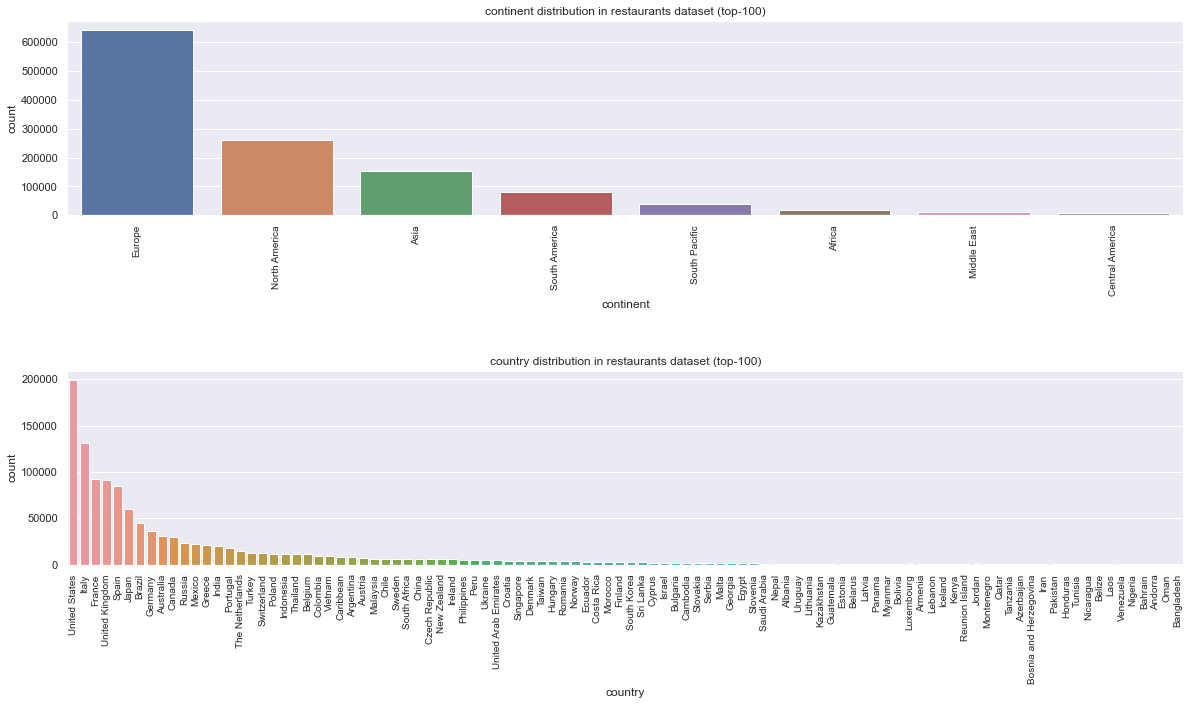

In [5]:
cat_features = ['continent', 'country']
top = 100
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
for i, col in enumerate(cat_features):
    tmp = df_restaurants.groupby([col])['location_id'].count().sort_values(ascending=False).head(top)
    sns.barplot(x=col, y="location_id", data=tmp.reset_index(), order=tmp.index, ax=ax[i])
    ax[i].tick_params(axis='x', labelrotation=90, labelsize=10)
    ax[i].set_ylabel('count')
    ax[i].set_title(f'{col} distribution in restaurants dataset (top-{top})')
plt.subplots_adjust(hspace=0.8)

explore numerical variables:

In [6]:
non_cat_features = df_restaurants.columns.difference(cat_features + ['location_id', 'ds'])
df_restaurants[non_cat_features].describe().T

,count,mean,std,min,25%,50%,75%,max
awards,383926.00,3.67,2.53,1.00,1.00,3.00,5.00,11.00
days_since_abandoned_cart,10192.00,160.23,91.30,0.00,85.00,161.00,221.00,365.00
days_since_claim,1212469.00,1339.62,869.81,-1.00,698.00,1146.00,1905.00,4616.00
days_since_creation,1191427.00,2310.74,1268.04,1.00,1264.00,2248.00,3149.00,5800.00
days_since_last_email,863440.00,30.36,42.89,1.00,11.00,17.00,21.00,276.00
days_since_last_review,1111006.00,394.61,478.77,1.00,49.00,152.00,678.00,5474.00
email_delivered_last_month,863420.00,3.76,3.93,0.00,1.00,3.00,5.00,606.00
email_opens_last_month,863420.00,0.93,1.81,0.00,0.00,0.00,1.00,66.00
geo_rank,1115935.00,619.98,1764.71,0.00,10.00,53.00,324.00,29151.00
geo_rank_all,1212469.00,1387.97,3092.44,0.00,32.00,162.00,974.00,18085.00


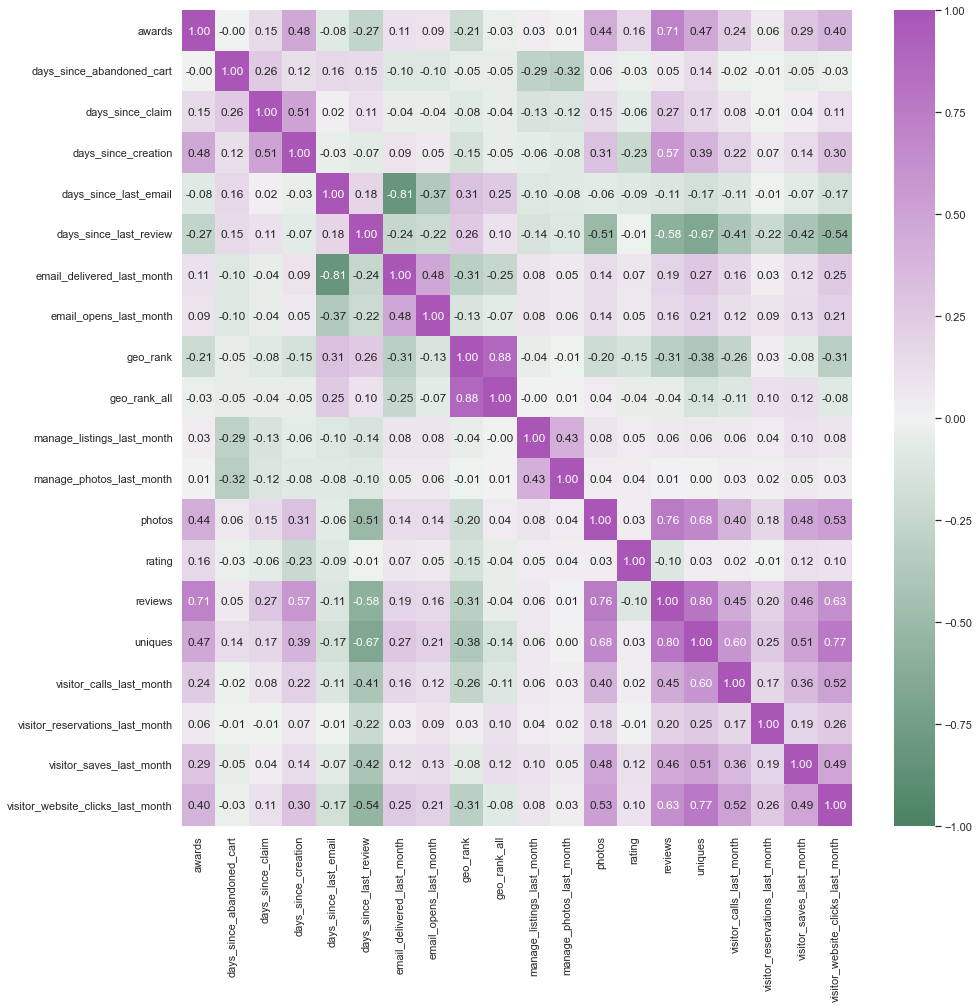

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax1 = sns.heatmap(df_restaurants[non_cat_features].corr(method='spearman'), 
                  annot=True, ax=ax, fmt='.2f', 
                  cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                  vmin=-1, vmax=1);

#### 2. subscription dataset

In [8]:
df_subscription.head()

,location_id,is_active,start_date,end_date
0,16674437,1,2022-01-08,2022-02-08
1,4276431,1,2022-01-22,2022-02-22
2,15658775,1,2022-01-07,2022-02-07
3,23423429,1,2022-01-19,2022-02-19
4,23526626,1,2022-01-06,2022-02-06


In [9]:
print(f'rows:              {df_subscription.shape[0]}')
print(f'start_date min:    {df_subscription["start_date"].min()}')
print(f'start_date max:    {df_subscription["start_date"].max()}')
print(f'end_date min:      {df_subscription["end_date"].min()}')
print(f'end_date max:      {df_subscription["end_date"].max()}')

rows:              7203
start_date min:    2022-01-02
start_date max:    2022-02-01
end_date min:      2022-02-02
end_date max:      2023-02-01


In [10]:
df_subscription['end_date'] = pd.to_datetime(df_subscription['end_date'])
df_subscription['start_date'] = pd.to_datetime(df_subscription['start_date'])
df_subscription.describe()

,location_id,is_active
count,7203.00,7203.00
mean,11870535.77,1.00
std,7702506.01,0.00
min,321605.00,1.00
25%,4080324.00,1.00
50%,12338380.00,1.00
75%,18955887.50,1.00
max,23869957.00,1.00


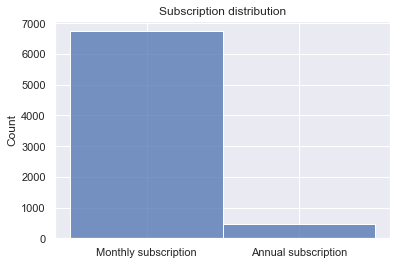

In [11]:
subscription_types = (df_subscription['end_date'] - df_subscription['start_date']).dt.days + 1
subscription_types = (subscription_types > 60).map({True: 'Annual subscription', False: 'Monthly subscription'})
sns.histplot(subscription_types)
plt.title('Subscription distribution');

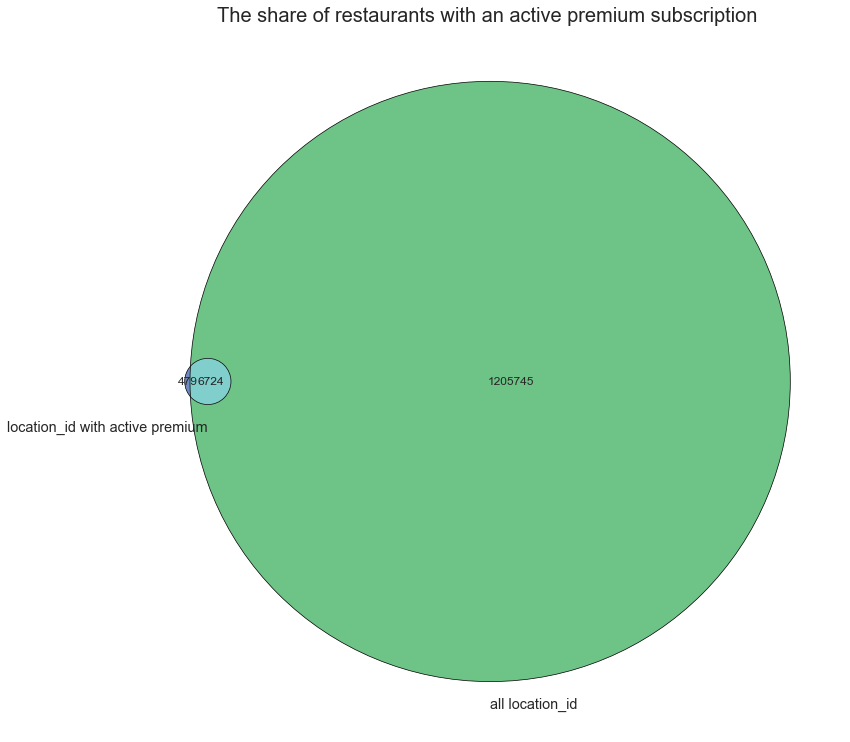

In [12]:
from matplotlib_venn import venn2, venn2_circles

fig, ax = plt.subplots(1,1,figsize=(13, 13))
subscr = set(df_subscription['location_id'])
all_rest = set(df_restaurants['location_id'])
out = venn2([subscr, all_rest], 
      set_colors=('#3E64AF', '#3EAF5D'), 
      set_labels = ('location_id with active premium', 
                    'all location_id'),
      alpha=0.75, ax=ax)
venn2_circles([subscr, all_rest], lw=0.7, ax=ax)
plt.title('The share of restaurants with an active premium subscription', fontdict={'fontsize': 20})
plt.show()

In [43]:
result = pd.DataFrame([['all restaurants', len(all_rest)],
                       ['restaurants with premium', len(subscr & all_rest)], 
                       ['premium, but not in the restaurants.csv', len(subscr - all_rest)]],
                      columns=['', 'number'])
result['%'] = (result['number']/len(all_rest)).map(lambda x: f'{x:.2%}')
result

,,number,%
0,all restaurants,1212469,100.00%
1,restaurants with premium,6724,0.55%
2,"premium, but not in the restaurants.csv",479,0.04%


#### 3. Check difference in distribution between all users, premium ones and those who has abandoned_cart, but without premium

In [13]:
df = df_restaurants.merge(df_subscription, how='left', on='location_id')

In [14]:
df_for_plots = df.copy()
df_for_plots['user_group'] = 'all'
df_for_plots = df_for_plots.append(df[df['is_active'] == 1])
df_for_plots['user_group'] = df_for_plots['user_group'].fillna('premium')
df_for_plots = df_for_plots.reset_index(drop=True)

In [15]:
tmp = sns.histplot(data=df_for_plots, x=col, stat='probability', ax=ax, hue='user_group', bins=20, 
                 common_norm=False, multiple ='dodge', shrink=0.6)

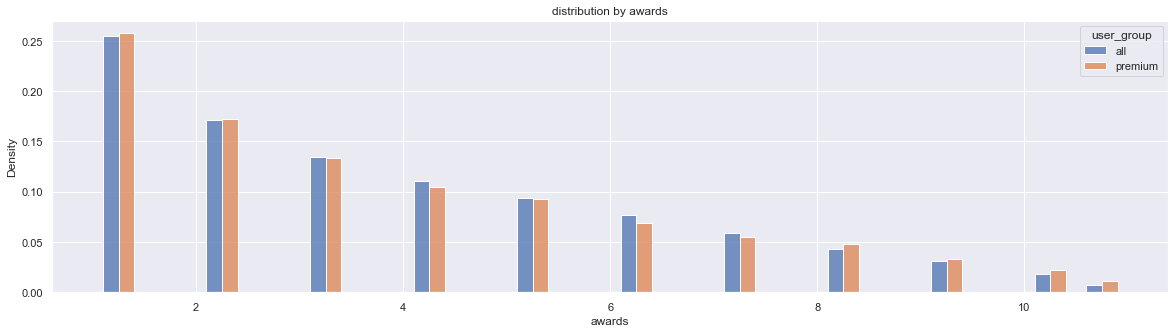

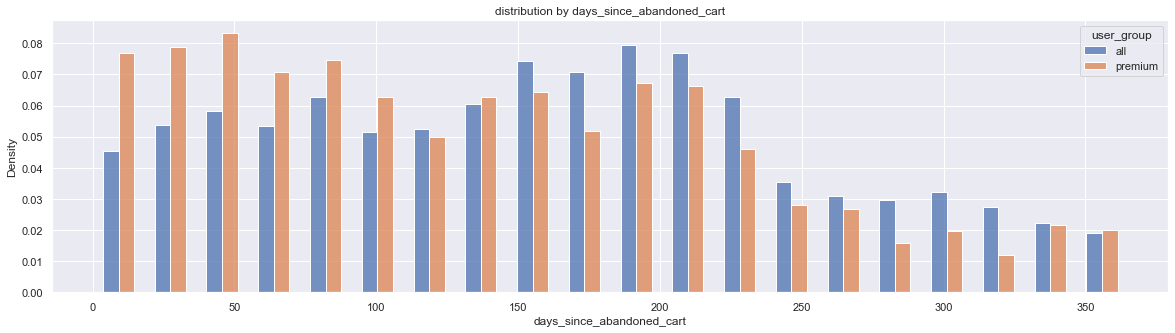

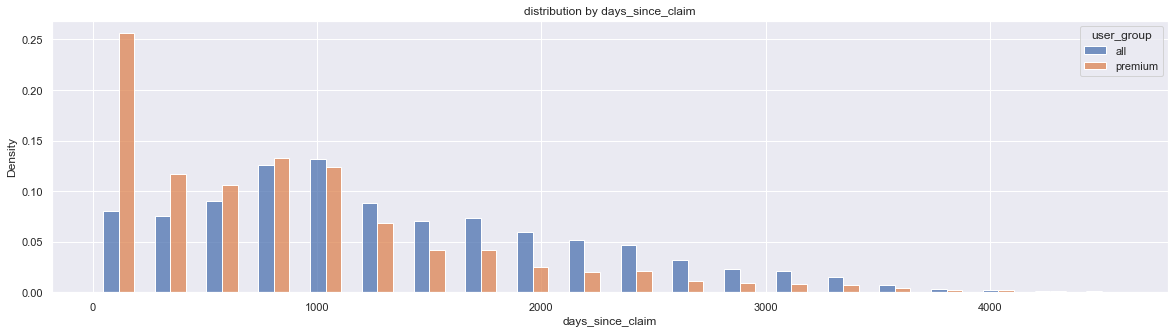

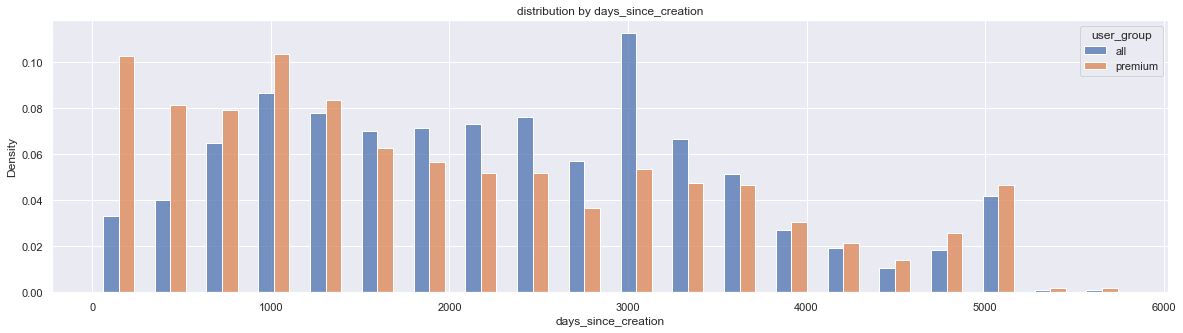

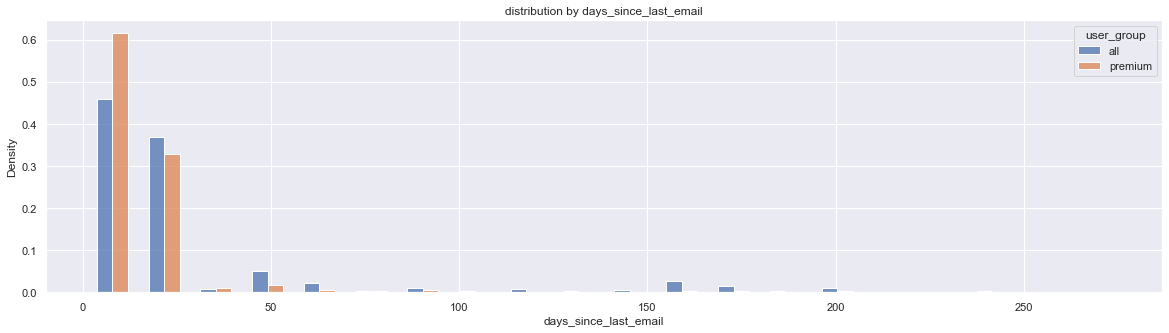

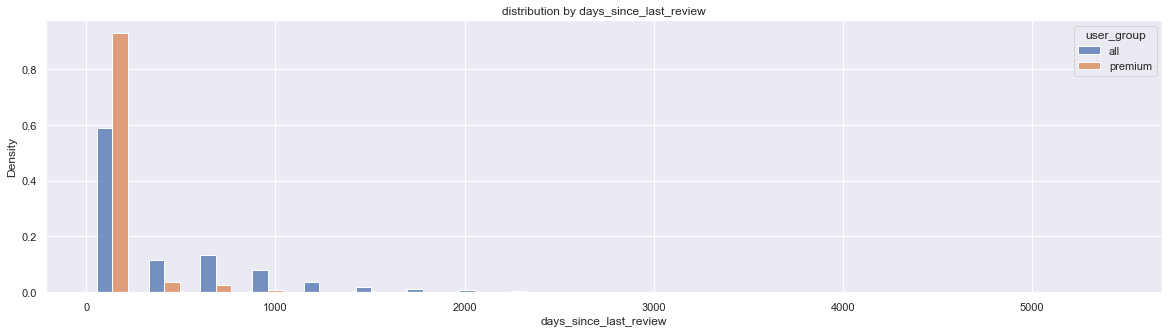

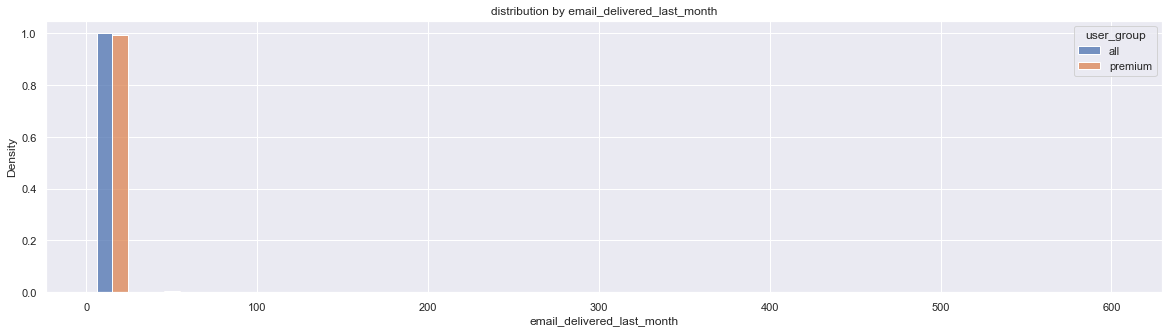

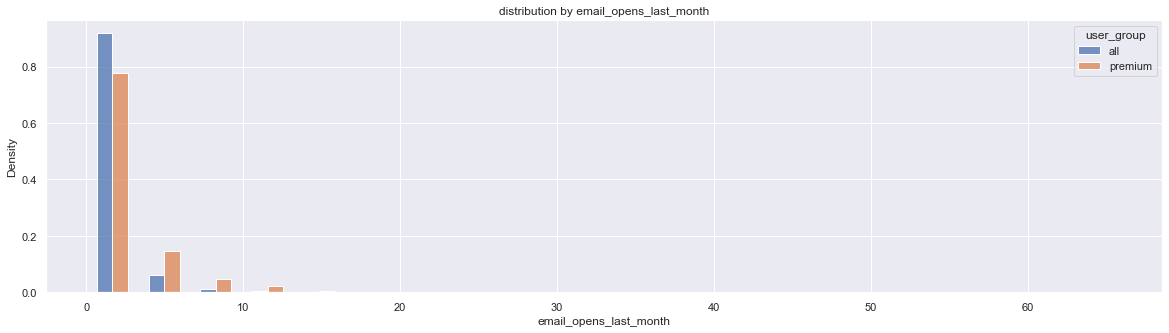

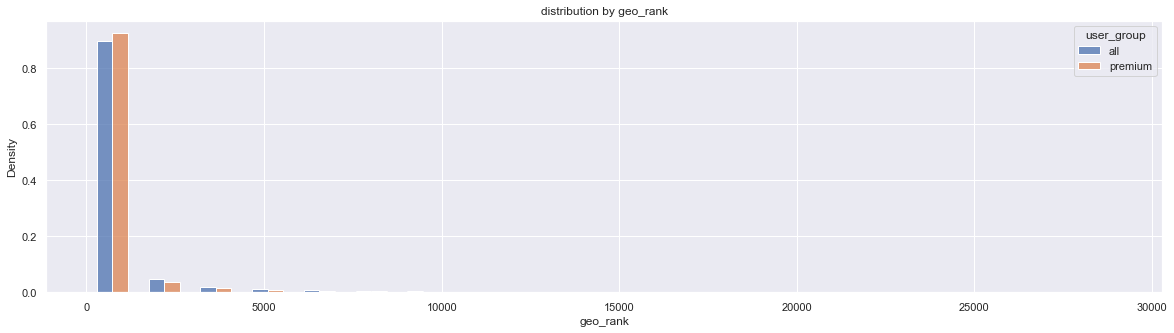

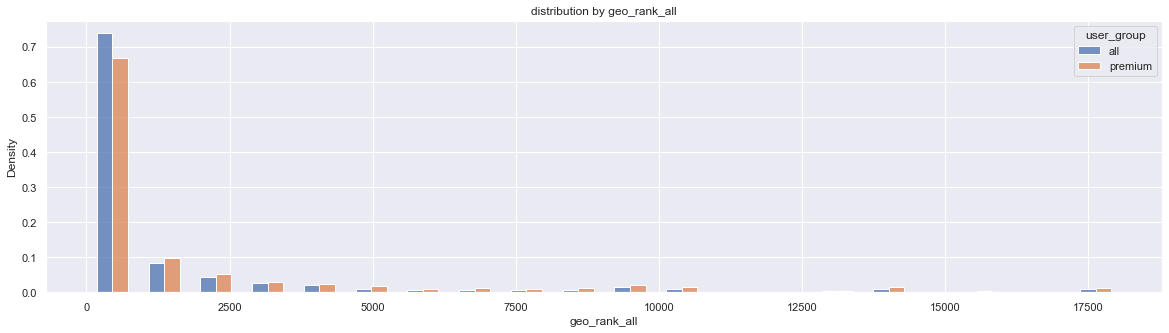

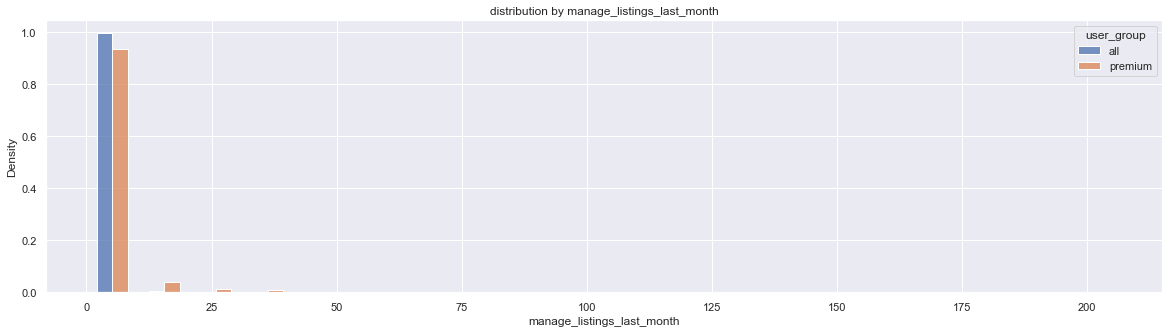

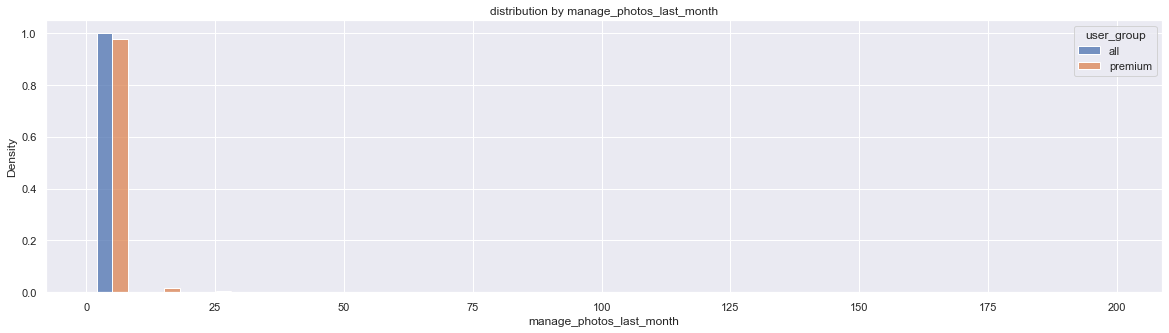

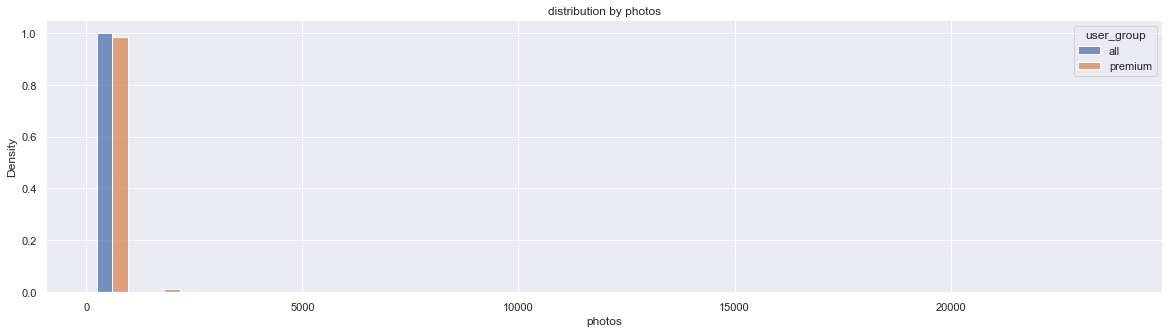

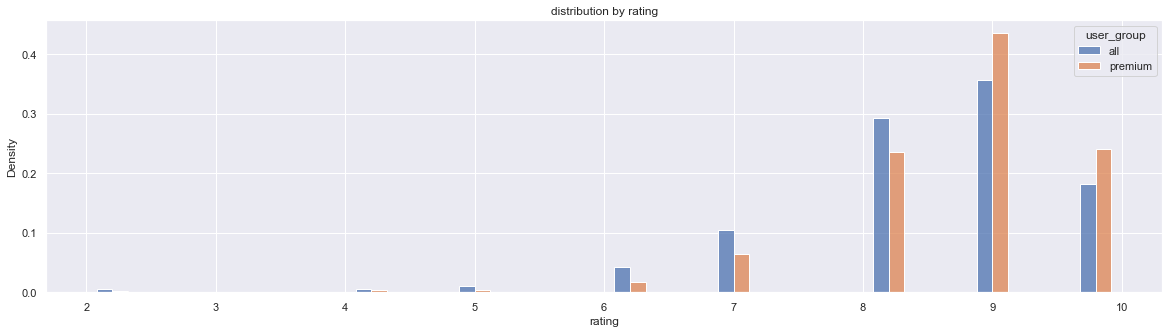

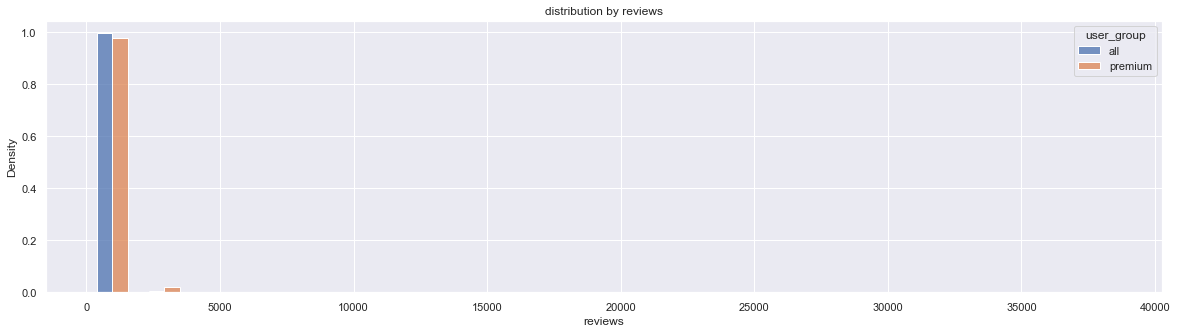

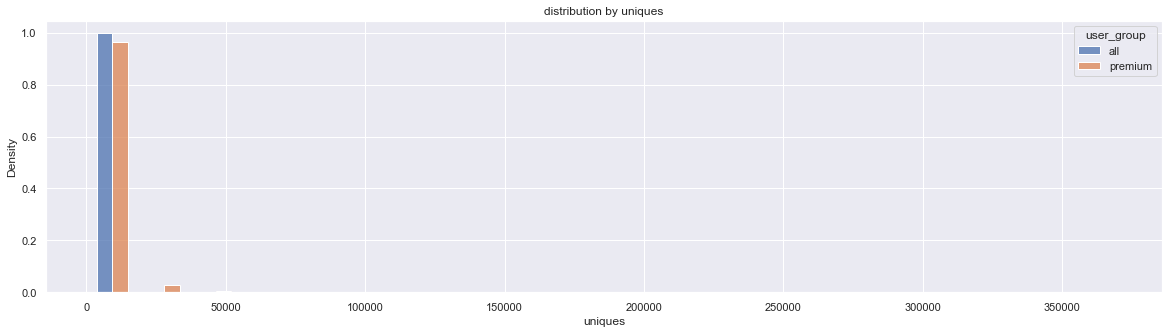

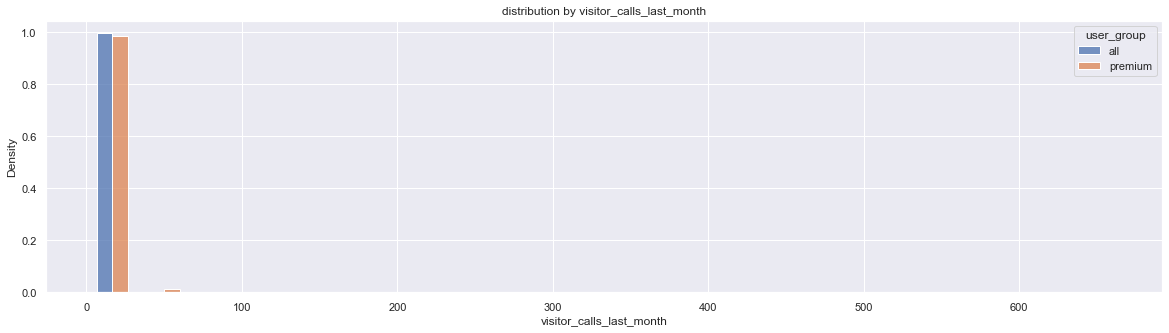

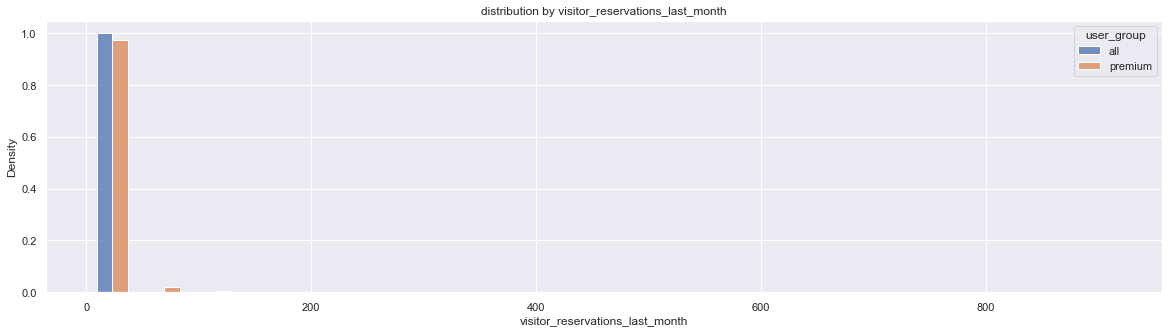

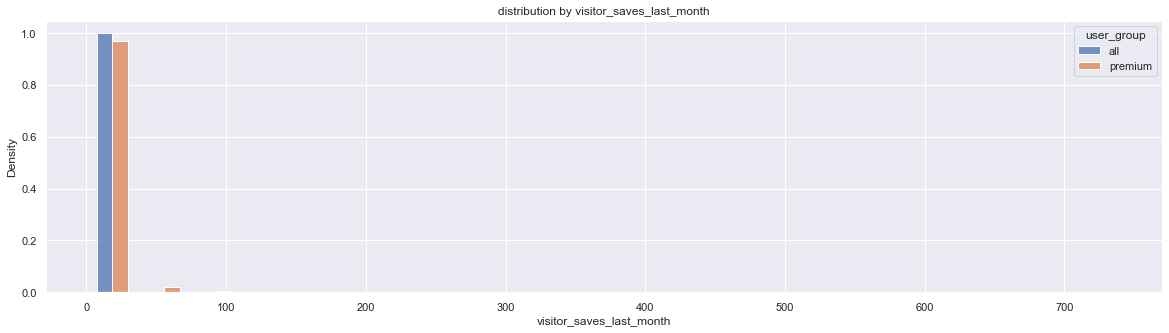

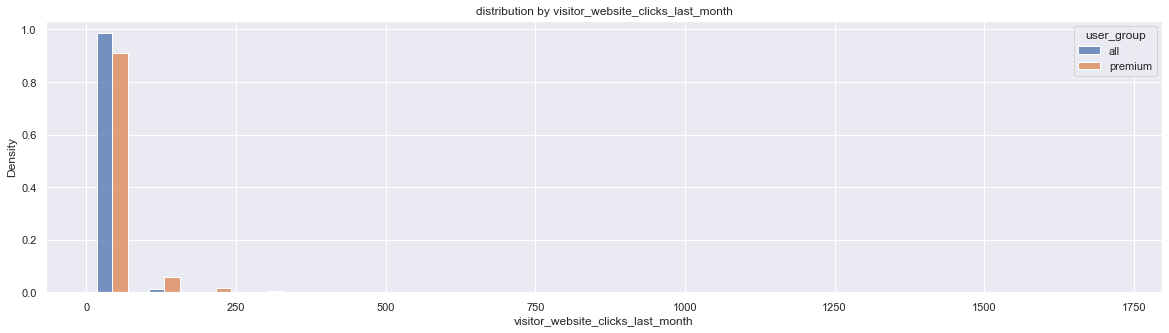

In [16]:
for i, col in enumerate(list(non_cat_features)):
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.histplot(data=df_for_plots, x=col, stat='probability', ax=ax, hue='user_group', bins=20, 
                 common_norm=False, multiple ='dodge', shrink=0.6)
    plt.ylabel('Density')
    plt.title(f'distribution by {col}')
    plt.show()

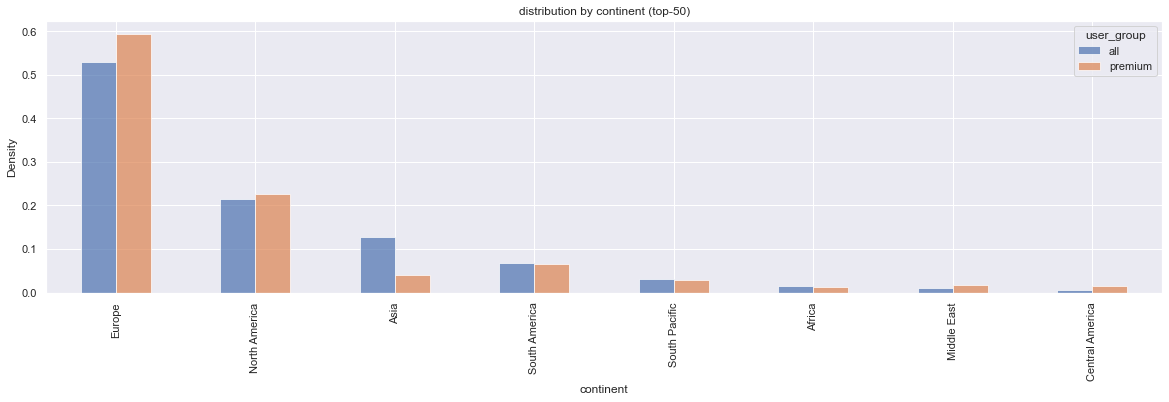

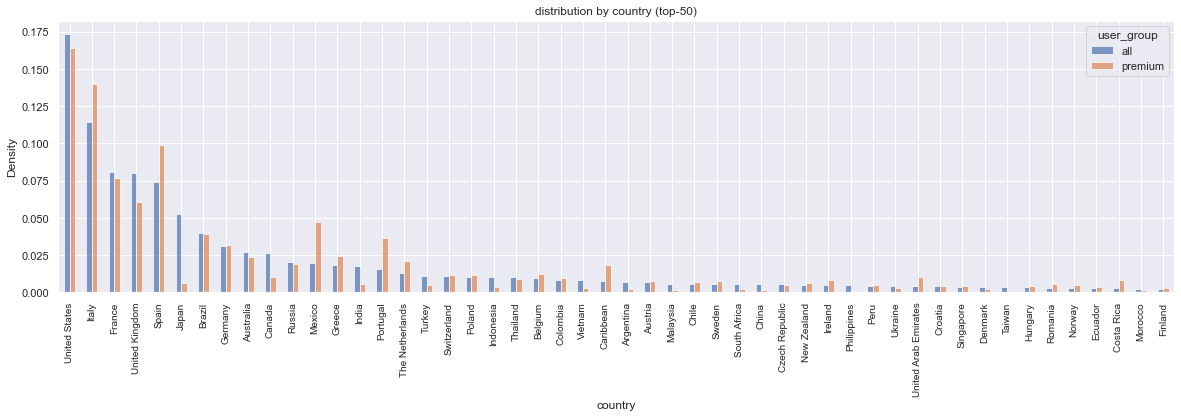

In [17]:
show_top = 50
for i, col in enumerate(cat_features):
    fig, ax = plt.subplots(figsize=(20, 5))
    res = df_for_plots.pivot_table(index=col, columns='user_group', values='location_id',aggfunc='count'
                            ).fillna(0)
    res = res.sort_values('all', ascending=False).head(show_top)
    (res/res.sum()).plot.bar(ax=ax, alpha=0.7)
    plt.ylabel('Density')
    if col == 'country':
        plt.xticks(rotation=90, fontsize=10)
    plt.title(f'distribution by {col} (top-{show_top})')
    plt.show()

## Model building process

It seems like this is not a classical recommendation task since we don't have any information about how restaurants bought other products.

I see three ways to solve this task (from simple to complex):

1. Identify a group of restaurants who have a premium subscription and calculate the distance to other restaurants (using cosine similarity, euclidean distance or other) based on the available features for each restaurant. The closer a restaurant is to premium restaurants, the more likely it is that this restaurant wants to use this premium feature.

    - Pros: It's a simple solution without using complex machine learning approaches (at least in model development).
    - Cons: I should choose features carefully (because all features will be important and I don't have a chance to check feature importance) and decrease feature dimension (to combat the curse of dimensionality in this situation, it's crucial).
2. Look at this task as a binary classification task, where 1 represents a premium restaurant and 0 represents others. However, I want to synthetically increase the weight of the 1 class. I want to do this because the 0 class is not actually a 0 class, and there are restaurants that could be premium if they knew about this option. By increasing the weight of the 1 class, I expect to see the following situation in the training process: if there are two restaurants with identical characteristics, but one of them belongs to the 1 class and the other one belongs to the 0 class, I want the model to learn that restaurants with these characteristics belong to the 1 class.

    - Pros: The feature engineering part is easier than in the previous solution, and we can see feature importance for the final solution.
    - Cons: I should determine an appropriate multiplier to increase the weight of the 1 class.
    
    I can choose one of the following models:
        1. Logistic regression (Pros: L1 regularization can help decrease feature dimension without additional transformations; Cons: I should handle NaN values carefully; we make the assumption that the two classes can be separated by a hyperplane, but the boundary can be more complicated.)
        2. Decision Tree (Pros: It can work with NaN values in the data; Cons: I should decrease feature dimension; boundary rules can be too simple; I need to combat overfitting.)
        3. Random Forest (Pros: It can work with NaN values in the data; Cons: It's difficult to find for now.)
        4. GBM (Pros: It can work with NaN values in the data; lightgbm allows the use of categorical features without transformation; Cons: It's difficult to find for now.)
        5. Neural networks (Pros: It can be very accurate; Cons: We should have much more data, experiment with layers/nodes, combat overfitting.)

3. Look at this task as a multiclass classification task: 1 represents a premium restaurant with a 1-month subscription, 2 represents a premium restaurant with a 1-year subscription, 0 - others.

    - Pros and Cons are similar to the previous solution, and I also need to be aware that 1 and 2 classes are unbalanced.
    
In a real situation, I would choose a few strategies and compare them with each other. Now I want to choose one strategy that is not too simple and not too complex, so I'm going to develop a solution for the binary classification task with Random Forest. Before developing this idea, it's better to perform some feature engineering and split users into train and test sets

### Feature engineering

I would like to add two more features: 

1. geo_rank_ratio = geo_rank/geo_rank_all - it can show how good restaurant is
2. email_opens_last_month_ratio = email_opens_last_month/email_delivered_last_month - it shows if owner is interested in any marketing communications

In [18]:
df['geo_rank_ratio'] = df['geo_rank']/df['geo_rank_all']
df.loc[df['geo_rank_all'] == 0, 'geo_rank_ratio'] = np.nan
df['geo_rank_ratio'] = df['geo_rank_ratio'].fillna(df['geo_rank_ratio'].mean())
df['email_opens_last_month_ratio'] = df['email_opens_last_month']/df['email_delivered_last_month']
df['email_opens_last_month_ratio'] = df['email_opens_last_month_ratio'].fillna(0)

Dataset has a lot of NaNs, let's fill it. I will fill it based on the general sense that our system is not broken and monitors any email statuses correctly, as well as other characteristics such as users' interactions with the website. NaN in these situations means that there were no interactions with the website or email (in a real situation, I would like to explore first to ensure that this assumption is true and that we have features of high quality).

Based on this assumption, I can replace NaN with 0 for the following features:
- email_delivered_last_month
- email_opens_last_month
- manage_listings_last_month
- manage_photos_last_month
- visitor_calls_last_month
- visitor_reservations_last_month
- visitor_saves_last_month
- visitor_website_clicks_last_month
- awards
- photos
- reviews
- uniques

I will fill NaN values in days_since_creation with days_since_claim because, for this feature, it seems like the best approximation.

The NaNs in the rating, days_since_last_email, days_since_abandoned_cart and days_since_last_review features are a bit controversial. Since I'm going to use a tree-based approach, I can replace them with some outlier value to show the model that this value is very different from others.

In [19]:
fillna_0 = ['email_delivered_last_month', 'email_opens_last_month', 'manage_listings_last_month',
            'manage_photos_last_month', 'visitor_calls_last_month', 'visitor_reservations_last_month', 
            'visitor_saves_last_month' , 'visitor_website_clicks_last_month', 'awards', 'photos', 
            'reviews', 'uniques']
df[fillna_0] = df[fillna_0].fillna(0)
df['days_since_creation'] = df['days_since_creation'].fillna(df['days_since_claim'])

controversional_nan = ['rating', 'days_since_last_email',
                       'days_since_last_review', 'days_since_abandoned_cart'] + ['geo_rank_ratio']
df[controversional_nan] = df[controversional_nan].fillna(-1000)

df.loc[df['days_since_claim'] < 0, 'days_since_claim'] = 0
df['days_since_creation'] = df['days_since_creation'].fillna(df['days_since_claim'])
df['geo_rank'] = df['geo_rank'].fillna(df['geo_rank_all']*df['geo_rank_ratio'])

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
location_id,1212469.00,9824417.93,6559322.02,321565.00,4058036.00,8669508.00,14770541.00,23823548.00
days_since_abandoned_cart,1212469.00,-990.25,106.26,-1000.00,-1000.00,-1000.00,-1000.00,365.00
days_since_last_email,1212469.00,-266.25,467.92,-1000.00,-1000.00,11.00,21.00,276.00
email_delivered_last_month,1212469.00,2.68,3.73,0.00,0.00,1.00,4.00,606.00
email_opens_last_month,1212469.00,0.66,1.58,0.00,0.00,0.00,1.00,66.00
manage_listings_last_month,1212469.00,0.21,1.80,0.00,0.00,0.00,0.00,207.00
manage_photos_last_month,1212469.00,0.07,1.04,0.00,0.00,0.00,0.00,201.00
visitor_calls_last_month,1212469.00,1.53,5.37,0.00,0.00,0.00,1.00,666.00
visitor_reservations_last_month,1212469.00,0.66,5.35,0.00,0.00,0.00,0.00,921.00
visitor_saves_last_month,1212469.00,0.89,4.82,0.00,0.00,0.00,0.00,741.00


### Model

split data on train/validation and group countries with small frequency

In [21]:
df_ = df.copy()
df['is_active'] = df['is_active'].fillna(0)

train, valid = train_test_split(df, test_size=0.2, stratify=df['is_active'])

top_names = train['country'].value_counts() / train.shape[0] 
top_names = top_names[top_names > 0.01].index

train.loc[~train['country'].isin(top_names), 'country'] = 'other'
valid.loc[~valid['country'].isin(top_names), 'country'] = 'other'
df.loc[~df['country'].isin(top_names), 'country'] = 'other'

C:\Users\Mary\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
features = list(df.columns.difference(['is_active', 'end_date', 'start_date', 'ds', 'location_id']))
cat_features = ['continent', 'country']
numeric_features = list(set(features) - set(cat_features))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", 'passthrough', numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

balanced_weights = (train['is_active'].shape[0]/ (2*np.bincount(train['is_active'])))
final_class_weights = balanced_weights * np.array([1, 2])
final_class_weights = {i: x for i, x in enumerate(final_class_weights)}

model = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", RandomForestClassifier(class_weight=final_class_weights))]
)

model = model.fit(train[features], train['is_active'])

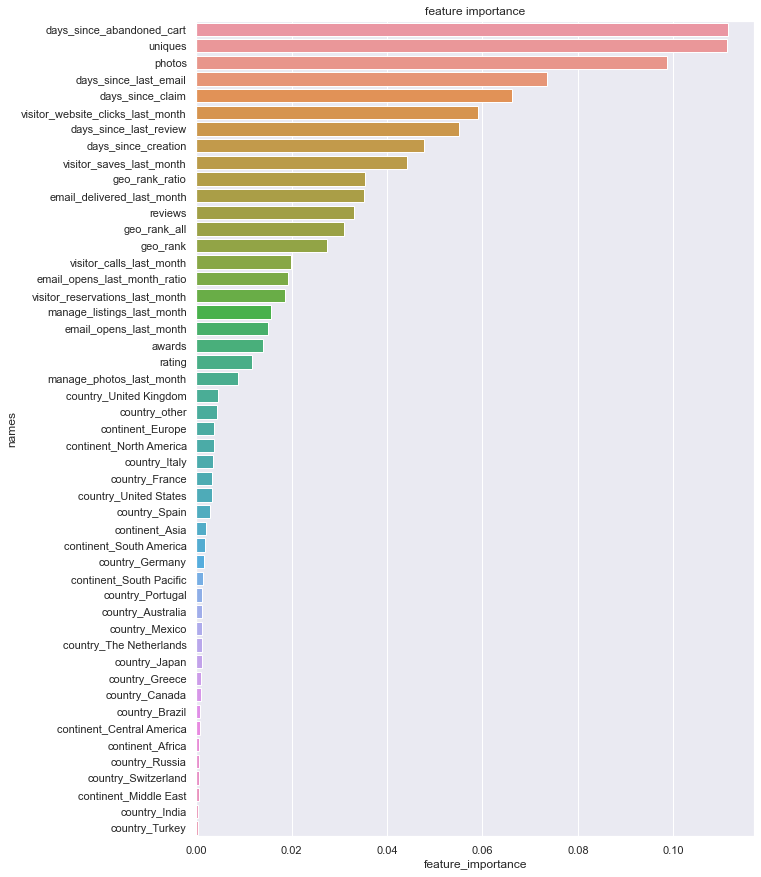

In [29]:
fig, ax = plt.subplots(figsize=(10, 15))
names = np.append(numeric_features, model['preprocessor'].transformers_[1][1].get_feature_names(cat_features))
result = pd.DataFrame([names, model.named_steps['classifier'].feature_importances_]).T
result.columns=['names', 'feature_importance']
sns.barplot(data=result.sort_values('feature_importance', ascending=False), y='names', x='feature_importance', ax=ax)
plt.title('feature importance');

### Performance evaluation

In [24]:
valid['predictions'] = model.predict_proba(valid[features])[:, 1]

<ipython-input-24-ac0b741a1c93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = model.predict_proba(valid[features])[:, 1]


In [30]:
k = 1345

valid_1_class = np.sum(valid['is_active'])
sorted_values = valid[['predictions', 'is_active']].sort_values('predictions', ascending=False)
top_sorted_values = sorted_values.head(k)
precision_k = top_sorted_values['is_active'].sum()/min(k, np.sum(sorted_values['is_active']))
recall_k = top_sorted_values['is_active'].sum()/np.sum(sorted_values['is_active'])
ndcg_k = np.sum(top_sorted_values['is_active']/np.log(2 + np.arange(k))) / np.sum(
    np.array([1]*min(k,valid_1_class) +[0]*(k-min(k,valid_1_class)))/np.log(2 + np.arange(k)))

print(f"""
1 class in test: {valid_1_class:.0f}

ndcg@{k}:      {ndcg_k}
precision@{k}: {precision_k}
recall@{k}:    {recall_k}
""")


1 class in test: 1345

ndcg@1345:      0.44373540389771293
precision@1345: 0.42230483271375463
recall@1345:    0.42230483271375463



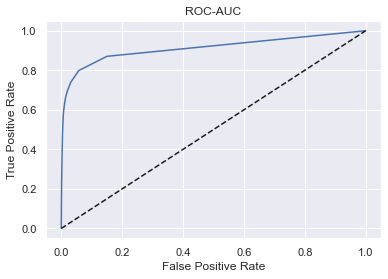

ROC-AUC (train): 1.00, ROC-AUC (validation): 0.91


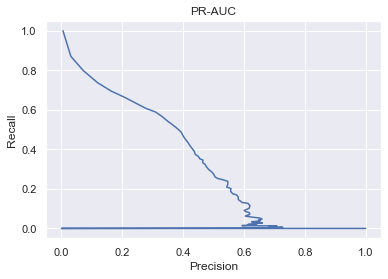

In [26]:
fpr, tpr, thresholds = roc_curve(valid['is_active'], valid['predictions'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.show()
print(f"""ROC-AUC (train): {roc_auc_score(train['is_active'], model.predict_proba(train[features])[:, 1])
:.2f}, ROC-AUC (validation): {roc_auc_score(valid['is_active'], valid['predictions']):.2f}""")

precision, recall, thresholds = precision_recall_curve(valid['is_active'], valid['predictions'])
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR-AUC')
plt.show()

### Result - sorted restaurants

Here are the results, sorted by the probability of subscription, for restaurants without premium.

It would be better to run AB-test to check model performance.

In [27]:
final_table = df.copy()
final_table['premium_probability'] = model.predict_proba(final_table[features])[:, 1]
final_table[final_table['is_active'] != 1].sort_values('premium_probability',ascending=False)

,location_id,continent,country,days_since_abandoned_cart,days_since_last_email,email_delivered_last_month,email_opens_last_month,manage_listings_last_month,manage_photos_last_month,visitor_calls_last_month,...,days_since_last_review,reviews,uniques,ds,is_active,start_date,end_date,geo_rank_ratio,email_opens_last_month_ratio,premium_probability
358326,16962819,Europe,Spain,186.00,4.00,18.00,4.00,0.00,0.00,7.00,...,6.00,114.00,7651.00,2022-01-01,0.00,NaT,NaT,0.13,0.22,0.80
236687,19261522,Europe,Italy,99.00,2.00,10.00,1.00,6.00,3.00,5.00,...,1.00,99.00,6400.00,2022-01-01,0.00,NaT,NaT,0.03,0.10,0.70
1029822,19735037,Europe,Germany,145.00,6.00,10.00,6.00,0.00,0.00,0.00,...,6.00,32.00,3603.00,2022-01-01,0.00,NaT,NaT,0.12,0.60,0.68
102256,23428089,Europe,Italy,148.00,6.00,5.00,1.00,0.00,0.00,13.00,...,6.00,165.00,6332.00,2022-01-01,0.00,NaT,NaT,0.01,0.20,0.67
772951,23731994,Europe,United Kingdom,38.00,7.00,6.00,0.00,20.00,4.00,1.00,...,20.00,11.00,183.00,2022-01-01,0.00,NaT,NaT,0.48,0.00,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424116,3978034,Europe,United Kingdom,-1000.00,11.00,6.00,0.00,0.00,0.00,4.00,...,1.00,215.00,1317.00,2022-01-01,0.00,NaT,NaT,0.07,0.00,0.00
424117,3979017,Europe,France,-1000.00,6.00,13.00,0.00,0.00,0.00,7.00,...,11.00,226.00,3206.00,2022-01-01,0.00,NaT,NaT,0.17,0.00,0.00
424118,3980967,Europe,Spain,-1000.00,21.00,4.00,0.00,0.00,0.00,0.00,...,1122.00,23.00,96.00,2022-01-01,0.00,NaT,NaT,0.45,0.00,0.00
424119,3982359,North America,Canada,-1000.00,-1000.00,0.00,0.00,0.00,0.00,0.00,...,1081.00,13.00,73.00,2022-01-01,0.00,NaT,NaT,1.00,0.00,0.00


##### Experimental plot. I'm trying to understand if there is some obvious border for class 1 in 2-dimension space

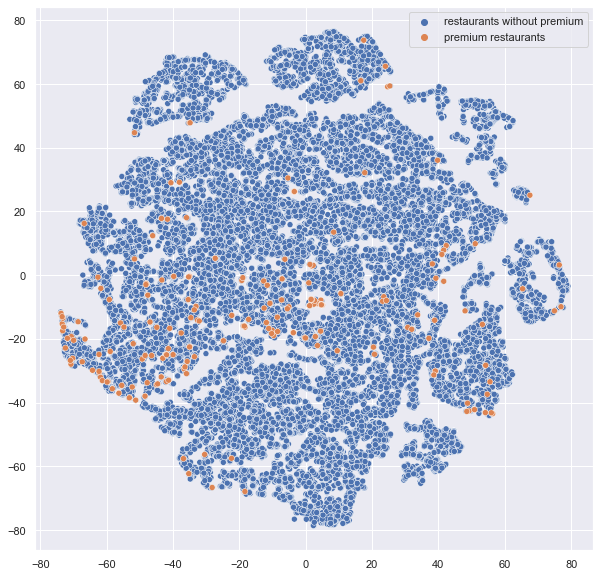

In [28]:
sample = df.groupby('is_active', group_keys=False).apply(lambda x: x.sample(frac=0.03))
tsne = TSNE()
df_two_dim = tsne.fit_transform(preprocessor.fit_transform(sample[features]))

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=df_two_dim[:,0], y=df_two_dim[:,1], 
                hue=sample['is_active'].map({1: 'premium restaurants', 0: 'restaurants without premium'}).values, ax=ax);